# Machine Learning Group Regression Project
Rae Huang, Leo Pei, Scott Virshup, and Dane Hamlett | UC Davis MSBA '18

Project:
https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting

Github:
https://github.com/svirshup/Retail-Forecasting

Code
* All members of the team must commit code on the project

Machine Learning
* Must use a Regression technique
* Must deploy model you created (not just calling out to Azure, AWS, or Google AI API).
* Must use a real data set (not fake data set, i.e. randomly generated numbers)

Juypter Notebook Documentation
* Must explain in detail accuracy of model
* Explain the tradeoffs you made
* Do exploratory data exploration

Bonus Opportunity (Up to 10% of Grade)

For groups that want to go above and beyond (truly exceptional effort) on the project you may receive bonus credit. Here are some ideas of what may be considered partial or full Bonus Credit.
* Build a Data Visualization Front End to Your API using Bokeh, Plotly, Shiny, or something similar.
* Build a true MVP you could pitch to a startup accelerator or Angel Investor in its current state.
* Incredible software engineering craftsmanship: monitoring, logging, load-testing, etc.
* Incredible Machine Learning craftsmanship and incorporation of class learnings and beyond.
* Exceptional showmanship in presentation
* You have an API deployed using Chalice/Flask or even R and the class can query it

<p id="toc"></p>
## Table of Contents

   - <a href="#one">Introduction</a>
   - <a href="#two">Import Libraries</a>
   - <a href="#three">Import Data</a>
   - <a href="#four">Explore Data</a>
   - <a href="#five">Feature Selection</a>
   - <a href="#six">Model Development</a>  
   - <a href="#seven">Model Validation</a>  
   - <a href="#eight">Recommendation</a>
   - <a href="#nine">References</a>

<hr style="width:50%;">
## <a id="one">Introduction</a>
<p><a href="#toc">Jump to top</a></p>

The focus of this analysis is on using data made available for the <a href="https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting" target="_blank">Recruit Restaurant Visitor Forecasting</a> project on <a href="https://www.kaggle.com/" target="_blank">Kaggle</a>, to implement a regression technique. The data set we will be leveraging, is comprised of Point of Sale (POS) transactional data, and reservation details for several Japanese restaurants. The data is made up of 8 files, derived from two Japanese websites that collect user data: Hot Pepper Gourmet (comparable to Yelp), providing reservation details, and AirREGI (comparable to Square), providing POS details and visitor counts.

Throughout the course of our analysis, our hope was to start by building out a straight-forward linear regression model to predict the number of visitors a store may expect for a given day. We would be using best-in-class exploratory techniques, and would incrementally enhance our model through the induction of new features. However, through the EDA process, and even as we started to generate our first linear model, we quickly realized that a linear regression technique would not be ideal for this data. We also chose to focus on one subset of data (AirREGI), which appeared to be a more holistic data set, comprised of adequate reservation and visitor data.

The biggest challenge we would face would be around the seasonality of the data. Without the data being stationary, and an initial R-squared value of ~.043, we were challenged with selecting an optimal modeling technique that would allow us to generate an accurate prediction. We opted for an ARIMA model, to provide that flexibility, and this is our journey.

<hr style="width:50%;">
## <a id="two">Import Libraries</a>
<p><a href="#toc">Jump to top</a></p>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Visualization specifications
color = sns.color_palette()
plt.style.use('ggplot')
%matplotlib inline

# Warning message supression
warnings.simplefilter("ignore")

/Users/scottvirshup/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<hr style="width:50%;">
## <a id="three">Import Data</a>
<p><a href="#toc">Jump to top</a></p>

In [2]:
# Import data

# for air_reserve, we must import it and split the dates so that we can join on the date later
air_reserve = pd.read_csv("/Users/scottvirshup/src/Retail-Forecasting/Data/air_reserve.csv",
                  parse_dates=[0], infer_datetime_format=True)
temp = pd.DatetimeIndex(air_reserve['visit_datetime'])
air_reserve['visit_date'] = temp.date
air_reserve['visit_time'] = temp.time

# for hpg_reserve, we must import it and split the dates so that we can join on the date later
hpg_reserve = pd.read_csv("/Users/scottvirshup/src/Retail-Forecasting/Data/hpg_reserve.csv",
                  parse_dates=[0], infer_datetime_format=True)
temp_2 = pd.DatetimeIndex(hpg_reserve['visit_datetime'])
hpg_reserve['visit_date'] = temp_2.date
hpg_reserve['visit_time'] = temp_2.time

air_store_info = pd.read_csv("/Users/scottvirshup/src/Retail-Forecasting/Data/air_store_info.csv")
air_visit_data = pd.read_csv("/Users/scottvirshup/src/Retail-Forecasting/Data/air_visit_data.csv")
date_info = pd.read_csv("/Users/scottvirshup/src/Retail-Forecasting/Data/date_info.csv")
store_id_relation = pd.read_csv("/Users/scottvirshup/src/Retail-Forecasting/Data/store_id_relation.csv")
hpg_store_info = pd.read_csv("/Users/scottvirshup/src/Retail-Forecasting/Data/hpg_store_info.csv")
air_final = pd.read_csv("/Users/scottvirshup/src/Retail-Forecasting/Data/air_final_data.csv")

### Preview Data

In [3]:
# Change the date types
air_reserve['visit_date'] = pd.to_datetime(air_reserve['visit_date'])
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime'])
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19:00:00
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19:00:00
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,19:00:00
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,20:00:00
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,20:00:00


In [4]:
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [5]:
# Change the name of visitors to something more intuitive
air_visit_data = air_visit_data.rename(index=str, columns = {"visitors":"total_visitors"})

# Change the date type
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
air_visit_data.head()

,air_store_id,visit_date,total_visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [6]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [7]:
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [8]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,11:00:00
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,13:00:00
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01,16:00:00
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016-01-01,17:00:00
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016-01-01,17:00:00


In [9]:
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


### Merge a few tables together based on the store ids

In [10]:
# Produce a master Air table
# Three primary tables are: air_reserve, air_visit_data, air_store_info
# Let's start by merging just the visit_data and store_info
air = pd.merge(air_store_info, air_visit_data, on='air_store_id', how='right')
air.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,visit_date,total_visitors
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-07-01,18
1,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-07-02,37
2,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-07-03,20
3,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-07-04,16
4,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-07-05,15


In [11]:
# Let's view another table we have created for a Regression analysis
air_final.head()

,Store_ID,Visit_Date,Visitors,Day_Of_Week,Holiday,Reservations,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,1/13/16,25,Wednesday,0,0,Dining bar,T≈çky≈ç-to Minato-ku Shibak≈çen,35.658068,139.751599
1,air_ba937bf13d40fb24,1/14/16,32,Thursday,0,0,Dining bar,T≈çky≈ç-to Minato-ku Shibak≈çen,35.658068,139.751599
2,air_ba937bf13d40fb24,1/15/16,29,Friday,0,0,Dining bar,T≈çky≈ç-to Minato-ku Shibak≈çen,35.658068,139.751599
3,air_ba937bf13d40fb24,1/16/16,22,Saturday,0,0,Dining bar,T≈çky≈ç-to Minato-ku Shibak≈çen,35.658068,139.751599
4,air_ba937bf13d40fb24,1/18/16,6,Monday,0,0,Dining bar,T≈çky≈ç-to Minato-ku Shibak≈çen,35.658068,139.751599


<hr style="width:50%;">
## <a id="four">Explore Data</a>
<p><a href="#toc">Jump to top</a></p>

### Reservations

### Map of restaurant locations
Using Folium for mapping. Dane Hamlett has a great example of it's use here:
* https://github.com/danehamlett/UC_Davis/blob/master/Classification/Retail%20Store%20Clustering%20Using%20KNN.ipynb

This page also has info on folium with a lot of examples that aren't covered here:
* http://folium.readthedocs.io/en/latest/quickstart.html

In [40]:
air_store_info['label'] = air_store_info['air_store_id'] + ", " + air_store_info['air_genre_name']

# Create genre subsets
genre_izakaya = air_store_info[air_store_info['air_genre_name'] == 'Izakaya']
genre_cafe = air_store_info[air_store_info['air_genre_name'] == 'Cafe/Sweets ']
genre_dining = air_store_info[air_store_info['air_genre_name'] == 'Dining bar']
genre_italy = air_store_info[air_store_info['air_genre_name'] == 'Italian/French']
genre_bar = air_store_info[air_store_info['air_genre_name'] == 'Bar/Cocktail']
genre_japanese = air_store_info[air_store_info['air_genre_name'] == 'Japanese food']
genre_other = air_store_info[air_store_info['air_genre_name'] == 'Other']
genre_korean = air_store_info[air_store_info['air_genre_name'] == 'Yakiniku/Korean food']
genre_western = air_store_info[air_store_info['air_genre_name'] == 'Western food']
genre_okonomiyaki = air_store_info[air_store_info['air_genre_name'] == 'Okonomiyaki/Monja/Teppanyaki']
genre_creative = air_store_info[air_store_info['air_genre_name'] == 'Creative cuisine']
genre_karaoke = air_store_info[air_store_info['air_genre_name'] == 'Karaoke/Party']
genre_international = air_store_info[air_store_info['air_genre_name'] == 'International cuisine']
genre_asian = air_store_info[air_store_info['air_genre_name'] == 'Asian']

In [41]:
# AIR Restaurant Locations
# Leverage the folium library for an interactive data visualization
stores_map = folium.Map(location=[37.972549, 139.862499],tiles='Stamen Terrain', zoom_start=5)
for name, row in genre_izakaya.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='green',icon='cutlery')).add_to(stores_map)
for name, row in genre_cafe.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='red',icon='cutlery')).add_to(stores_map)
for name, row in genre_dining.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='blue',icon='cutlery')).add_to(stores_map)
for name, row in genre_italy.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='purple',icon='cutlery')).add_to(stores_map)
for name, row in genre_bar.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='yellow',icon='cutlery')).add_to(stores_map)
for name, row in genre_japanese.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='orange',icon='cutlery')).add_to(stores_map)
for name, row in genre_other.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='gray',icon='cutlery')).add_to(stores_map)
for name, row in genre_korean.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='darkpurple',icon='cutlery')).add_to(stores_map)
for name, row in genre_western.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='lightgray',icon='cutlery')).add_to(stores_map)
for name, row in genre_okonomiyaki.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='lightred',icon='cutlery')).add_to(stores_map)
for name, row in genre_creative.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='beige',icon='cutlery')).add_to(stores_map)
for name, row in genre_karaoke.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='white',icon='cutlery')).add_to(stores_map)
for name, row in genre_international.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='black',icon='cutlery')).add_to(stores_map)
for name, row in genre_asian.iterrows():
    folium.Marker([row["latitude"],row["longitude"]],popup=row["label"],icon=folium.Icon(color='lightblue',icon='cultery')).add_to(stores_map)
stores_map

In [12]:
# Number of stores in the air system
air_reserve.air_store_id.nunique()

314

In [13]:
# Metadata diagnostics
air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 6 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null object
reserve_datetime    92378 non-null datetime64[ns]
reserve_visitors    92378 non-null int64
visit_date          92378 non-null datetime64[ns]
visit_time          92378 non-null object
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 4.2+ MB


In [14]:
# Visitor diagnostics
air_reserve.describe()

,reserve_visitors
count,92378.000000
mean,4.481749
std,4.919669
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,100.000000


In [ ]:
# Let's review the reservation data for stores in the air system
#air_reserve.plot.box(by='reserve_visitors',figsize=(18,10),title='Air Reservation Visitors',color='blue')
#plt.show()

<p></p>
![Chart Image](https://user-images.githubusercontent.com/30674288/37231585-8fb9e762-23a0-11e8-98fa-333584806bea.png)<p></p>


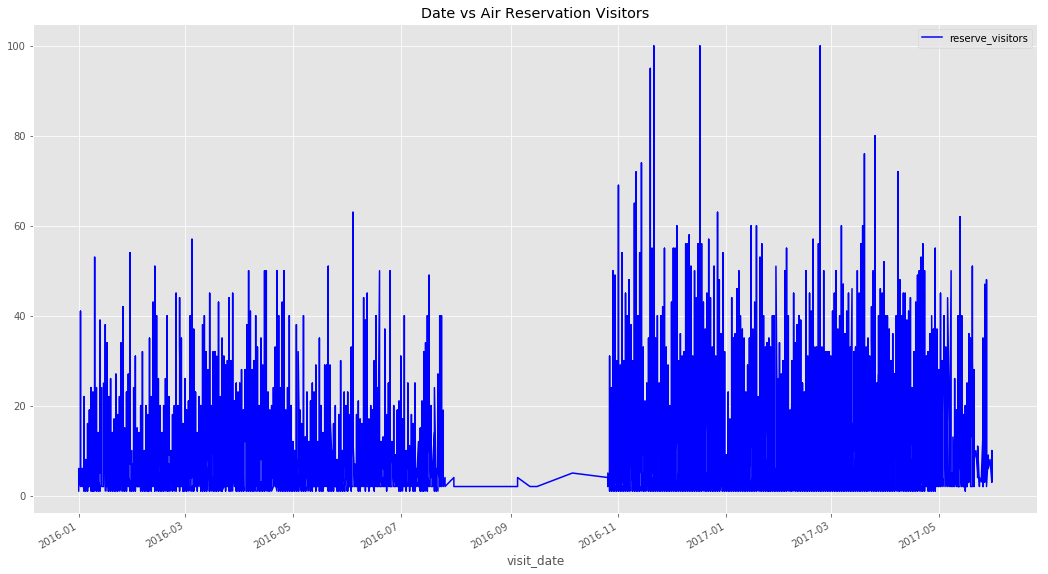

In [16]:
# Let's review the reservation data for stores in the air system by date
air_reserve.plot.line(x='visit_date', y='reserve_visitors',figsize=(18,10),title='Date vs Air Reservation Visitors',color='blue')
plt.show()

In [17]:
# Let's create a data frame to group data by time
air_reservations = pd.DataFrame(air_reserve.groupby(['visit_time'])['reserve_visitors'].sum().reset_index())
air_reservations.head()

,visit_time,reserve_visitors
0,00:00:00,2758
1,01:00:00,2190
2,02:00:00,1218
3,03:00:00,707
4,04:00:00,414


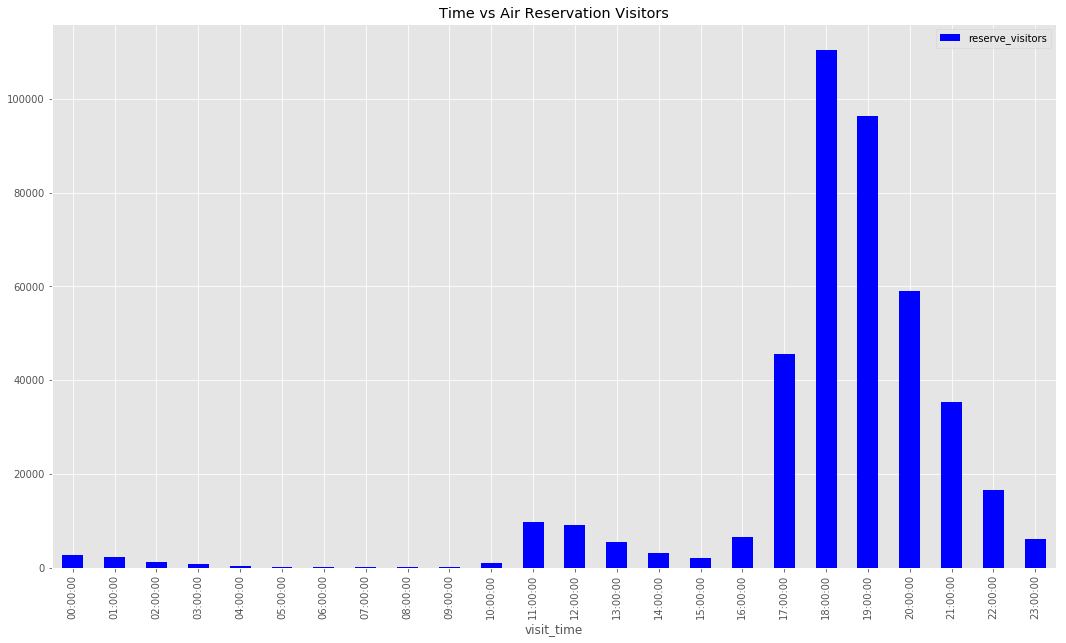

In [18]:
# Let's review the reservation data for stores in the air system by date
air_reservations.plot.bar(x='visit_time', y='reserve_visitors',figsize=(18,10),title='Time vs Air Reservation Visitors',color='blue')
plt.show()

In [19]:
# Number of stores in the hpg system
hpg_reserve.hpg_store_id.nunique()

13325

In [20]:
# Metadata diagnostics
hpg_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 6 columns):
hpg_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors    int64
visit_date          object
visit_time          object
dtypes: int64(1), object(5)
memory usage: 91.6+ MB


In [21]:
# Visitor diagnostics
hpg_reserve.describe()

,reserve_visitors
count,2.000320e+06
mean,5.073785e+00
std,5.416172e+00
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,6.000000e+00
max,1.000000e+02


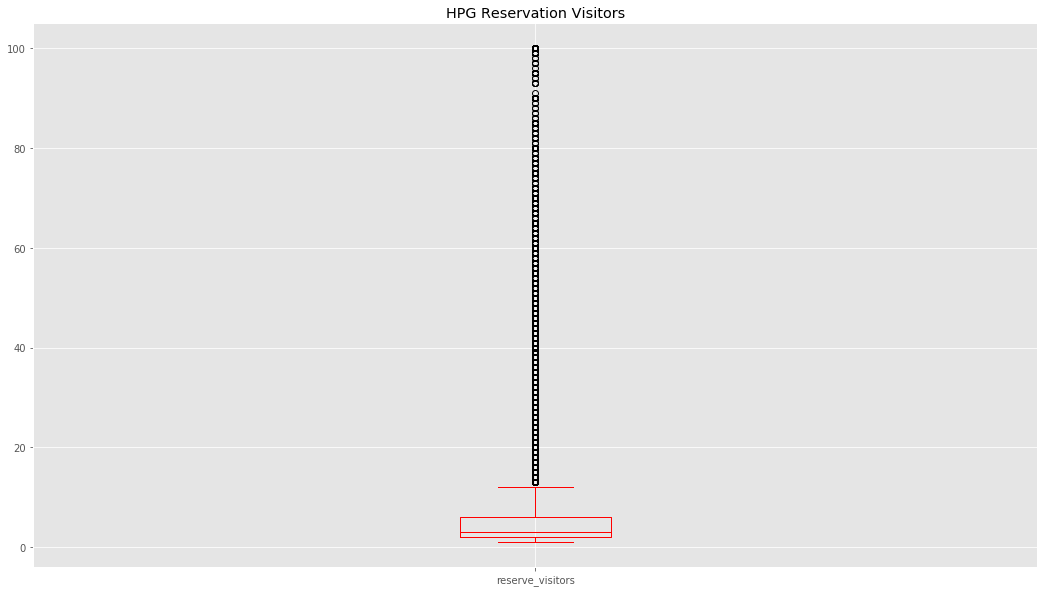

In [22]:
# Let's review the reservation data for stores in the air system
hpg_reserve.plot.box(by='reserve_visitors',figsize=(18,10),title='HPG Reservation Visitors',color='red')
plt.show()

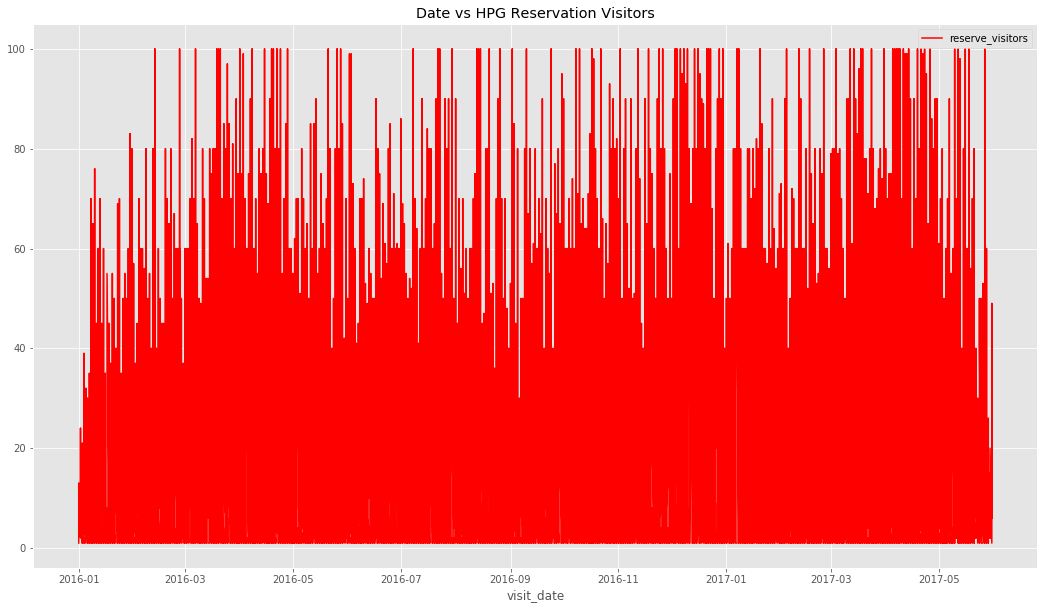

In [23]:
# Let's review the reservation data for stores in the air system by date
hpg_reserve.plot.line(x='visit_date', y='reserve_visitors',figsize=(18,10),title='Date vs HPG Reservation Visitors',color='red')
plt.show()

In [24]:
# Let's create a data frame to group data by time
hpg_reservations = pd.DataFrame(hpg_reserve.groupby(['visit_time'])['reserve_visitors'].sum().reset_index())
hpg_reservations.head()

,visit_time,reserve_visitors
0,00:00:00,12443
1,01:00:00,8113
2,02:00:00,2948
3,03:00:00,1022
4,04:00:00,875


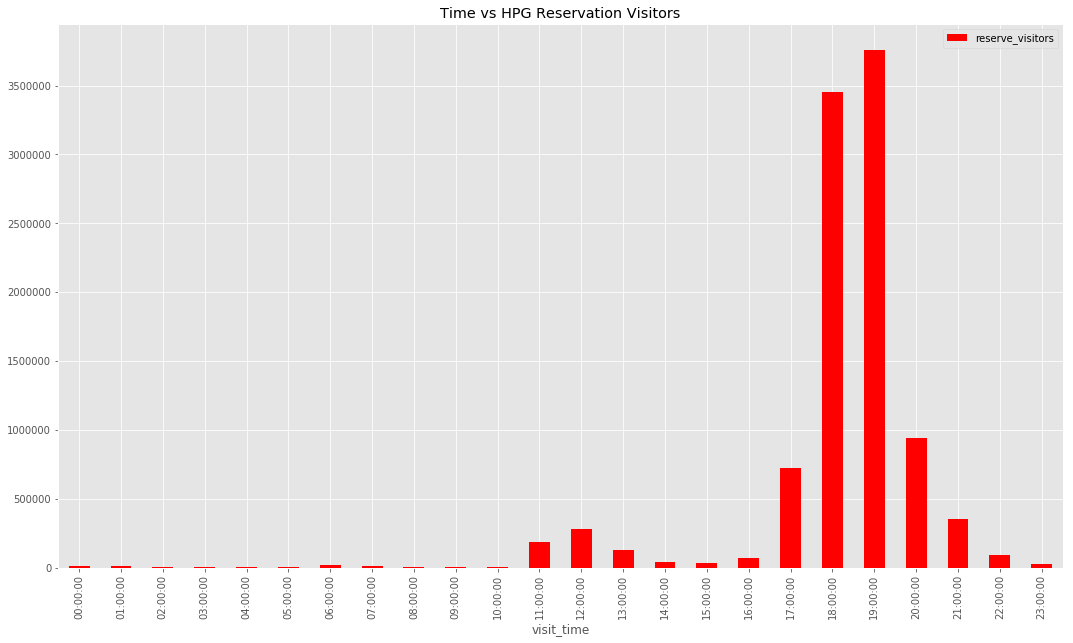

In [25]:
# Let's review the reservation data for stores in the air system by date
hpg_reservations.plot.bar(x='visit_time', y='reserve_visitors',figsize=(18,10),title='Time vs HPG Reservation Visitors',color='red')
plt.show()

In [26]:
# The datasets look somewhat similar but we are going to focus on the Air Reserve data set
air_visit_data.air_store_id.value_counts().head()

air_5c817ef28f236bdf    477
air_36bcf77d3382d36e    476
air_d97dabf7aae60da5    476
air_a083834e7ffe187e    476
air_232dcee6f7c51d37    475
Name: air_store_id, dtype: int64

In [27]:
# Create a subset of the dataframe for the store with the most datapoints
air_visit_subset = air_visit_data.loc[air_visit_data['air_store_id'] == 'air_5c817ef28f236bdf']
air_visit_subset=air_visit_subset.drop('air_store_id', axis=1)
air_visit_subset.head()

,visit_date,total_visitors
158602,2016-01-02,24
158603,2016-01-03,49
158604,2016-01-04,10
158605,2016-01-05,2
158606,2016-01-06,9


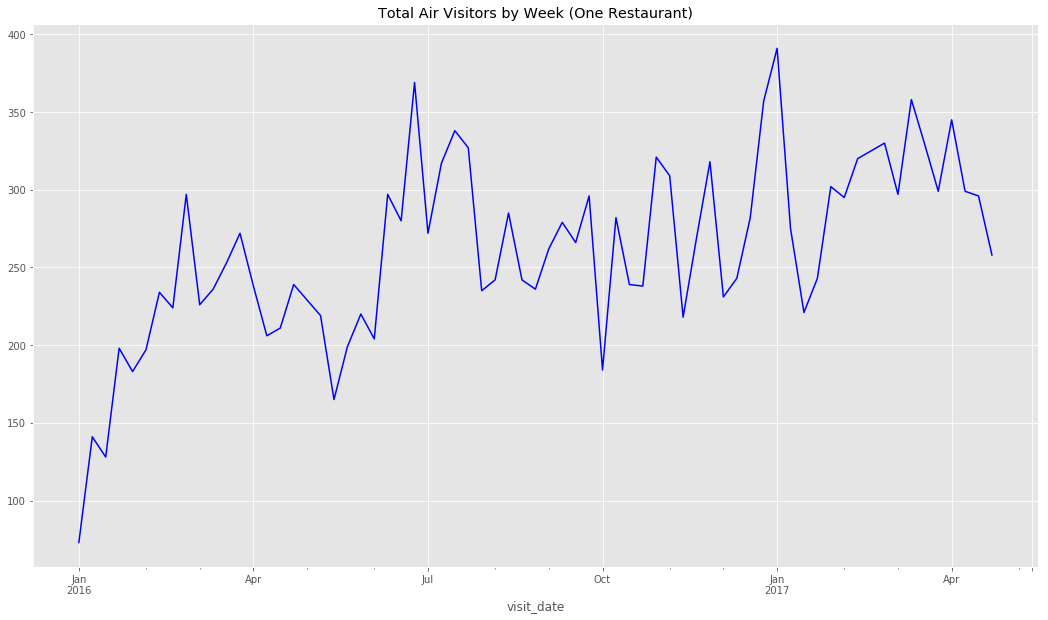

In [28]:
# Timeline of visitors per day for one restaurant in the Air system
date_group = air_visit_subset.groupby('visit_date')
visitors_totals = date_group.total_visitors.sum()

# set the date as the index and then plot by week
air_visit_subset_plot = air_visit_subset.set_index('visit_date')
visit_plot = air_visit_subset_plot.resample('W',how=sum).plot(title="Total Air Visitors by Week (One Restaurant)",legend=None,figsize=(18,10),color='blue')

####
# There certainly appears to be an increase in visitors over time for this store.
# This could be indicative of the number of visitors being non-stationary
####

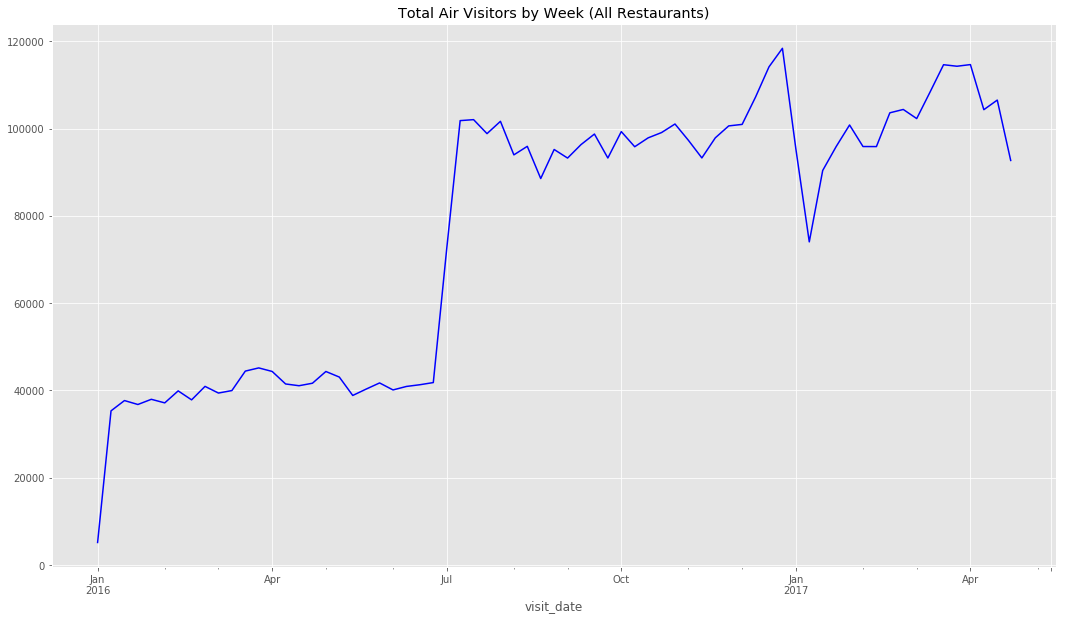

In [29]:
# Timeline of visitors per week for the entire air system
date_group = air_visit_data.groupby('visit_date')
visitors_totals = date_group.total_visitors.sum()

# set the date as the index and then plot by week
air_visit_data_plot = air_visit_data.set_index('visit_date')
visit_plot = air_visit_data_plot.resample('W',how=sum).plot(title="Total Air Visitors by Week (All Restaurants)",legend=None,figsize=(18,10),color='blue')

####
# When you look at it for the whole dataset, you can see large spikes, which means it is likely large increases
# to the number of stores in the dataset at that time
####

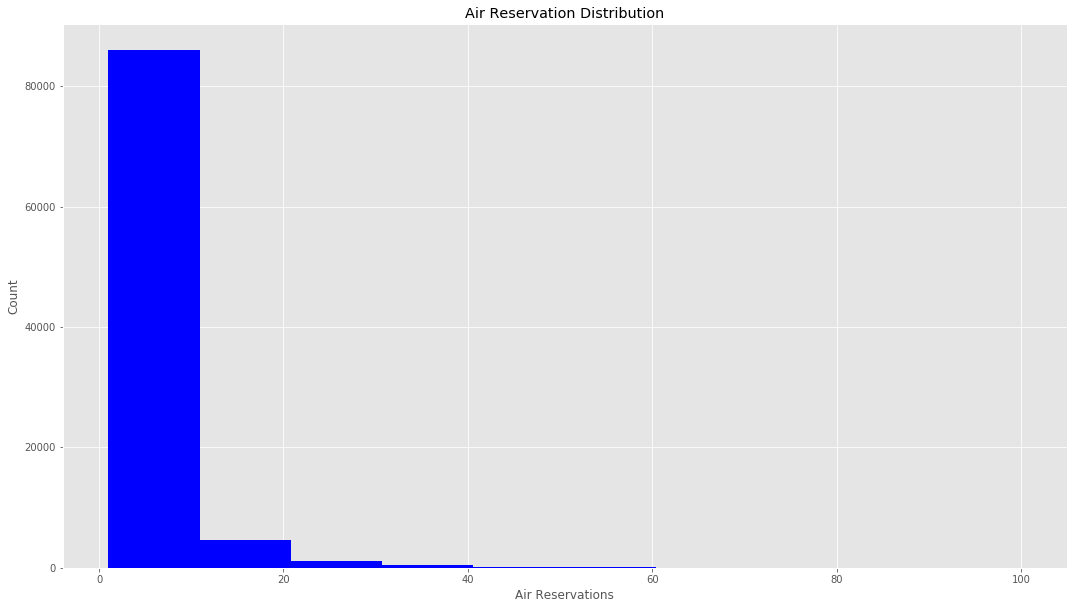

In [30]:
# Let's look at a distribution of the resevervations within the air system
air_disti_df = air_reserve[["reserve_visitors"]].copy()

# Create a subset to analyze and confirm the distribution of the data
pd.DataFrame.hist(air_disti_df, figsize = [18,10],color='blue')
plt.title('Air Reservation Distribution')
plt.xlabel('Air Reservations')
plt.ylabel('Count')
plt.show()

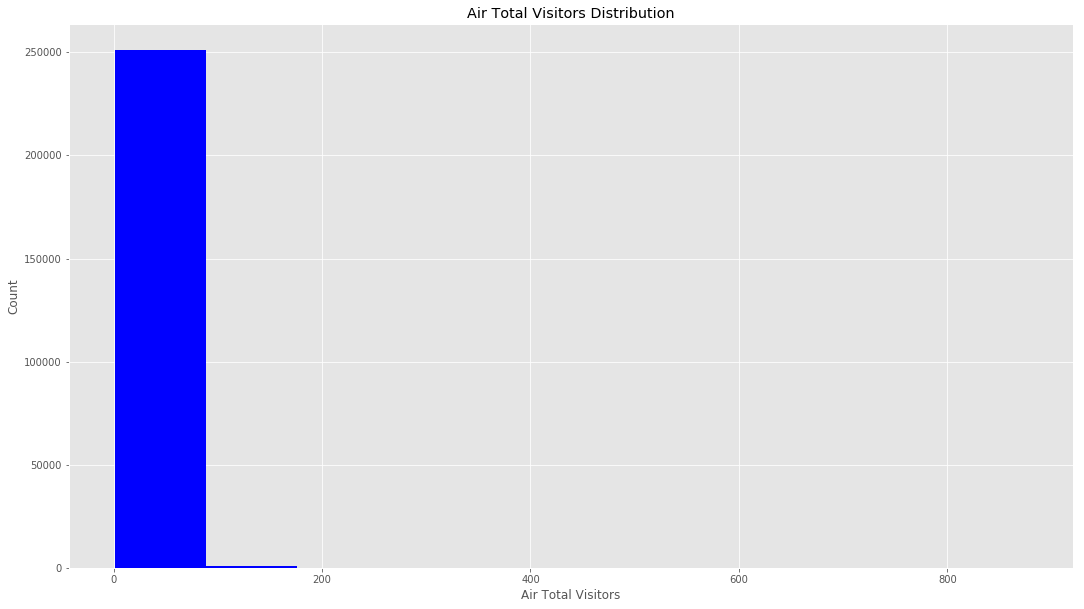

In [31]:
# Let's look at a distribution of the visitors within the air system
air_disti_df_2 = air_visit_data[["total_visitors"]].copy()

# Create a subset to analyze and confirm the distribution of the data
pd.DataFrame.hist(air_disti_df_2, figsize = [18,10],color='blue')
plt.title('Air Total Visitors Distribution')
plt.xlabel('Air Total Visitors')
plt.ylabel('Count')
plt.show()

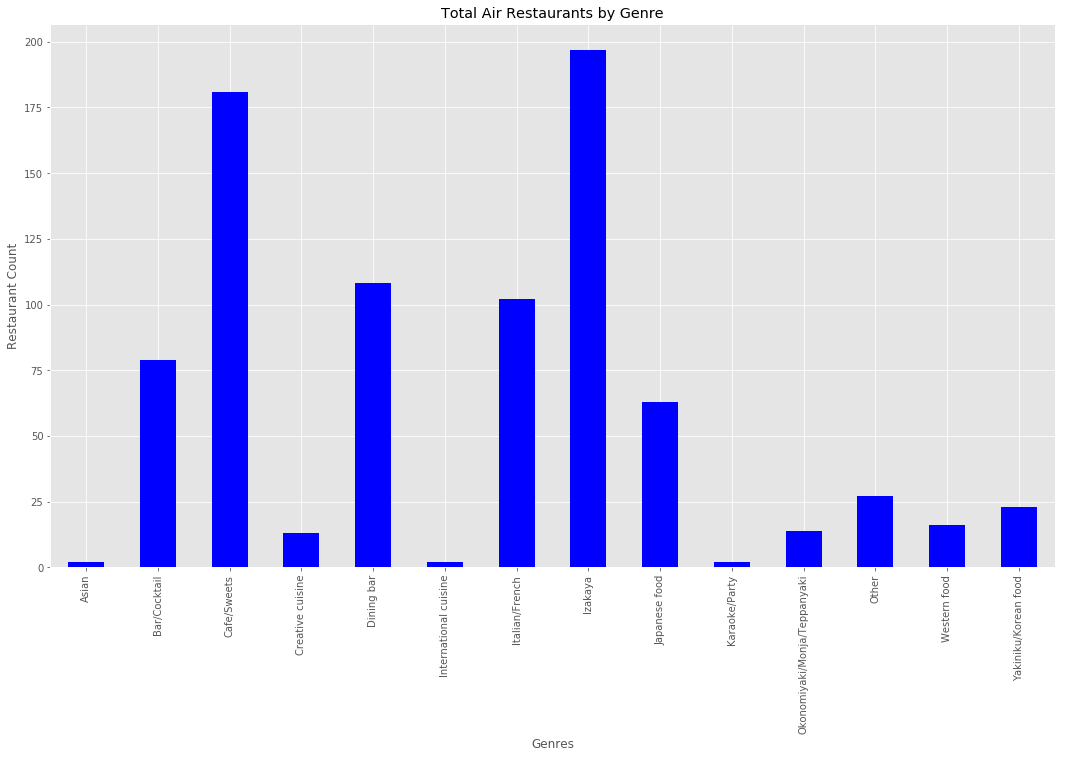

In [32]:
# Graph air genre counts
air_genre_counts = air_store_info[['air_genre_name', 'air_store_id']]
genre_group = air_genre_counts.groupby('air_genre_name')
genre_totals = genre_group.air_store_id.nunique()

my_plot = genre_totals.plot(kind='bar',legend=None,title="Total Air Restaurants by Genre",figsize=(18,10),color='blue')
my_plot.set_xlabel("Genres")
my_plot.set_ylabel("Restaurant Count")
plt.show()

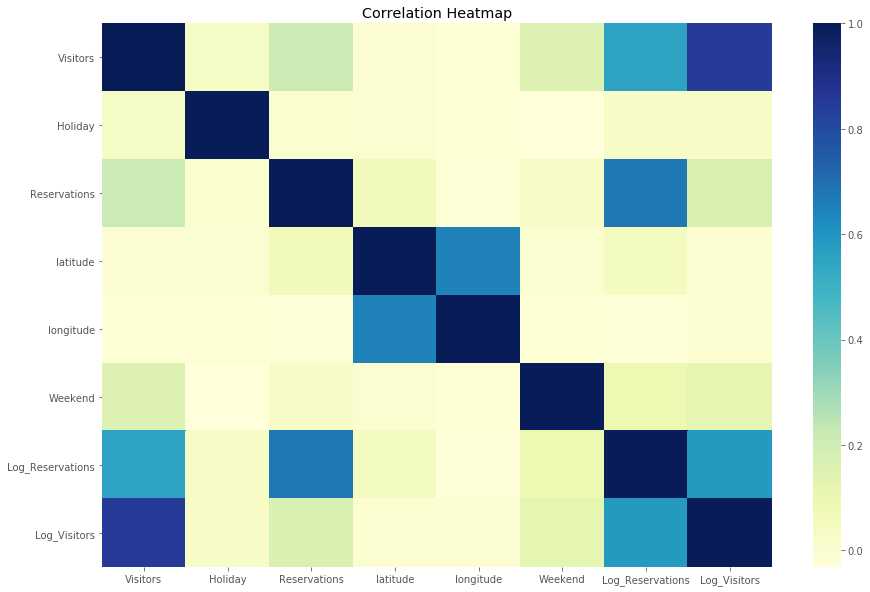

In [33]:
# Create a correlation heat map to assess variables for a linear regression model
air_final['Weekend'] = ((air_final['Day_Of_Week'] == 'Saturday') | (air_final['Day_Of_Week'] == 'Sunday')).astype(int)
air_final['Log_Reservations'] = air_final.apply(lambda row: np.log10(row.Reservations), axis=1)
air_final['Log_Visitors'] = air_final.apply(lambda row: np.log10(row.Visitors), axis=1)
corr_final = air_final.corr()
plt.subplots(figsize=(15,10))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
sns.heatmap(corr_final, 
            xticklabels=corr_final.columns.values,
            yticklabels=corr_final.columns.values,
            cmap="YlGnBu")
plt.show()

In [34]:
# Create a correlation matrix to assess variable relationship
df_disti = air_final[["Reservations","Visitors", "Weekend"]].copy()
df_disti.corr()

,Reservations,Visitors,Weekend
Reservations,1.000000,0.206765,0.027385
Visitors,0.206765,1.000000,0.157300
Weekend,0.027385,0.157300,1.000000


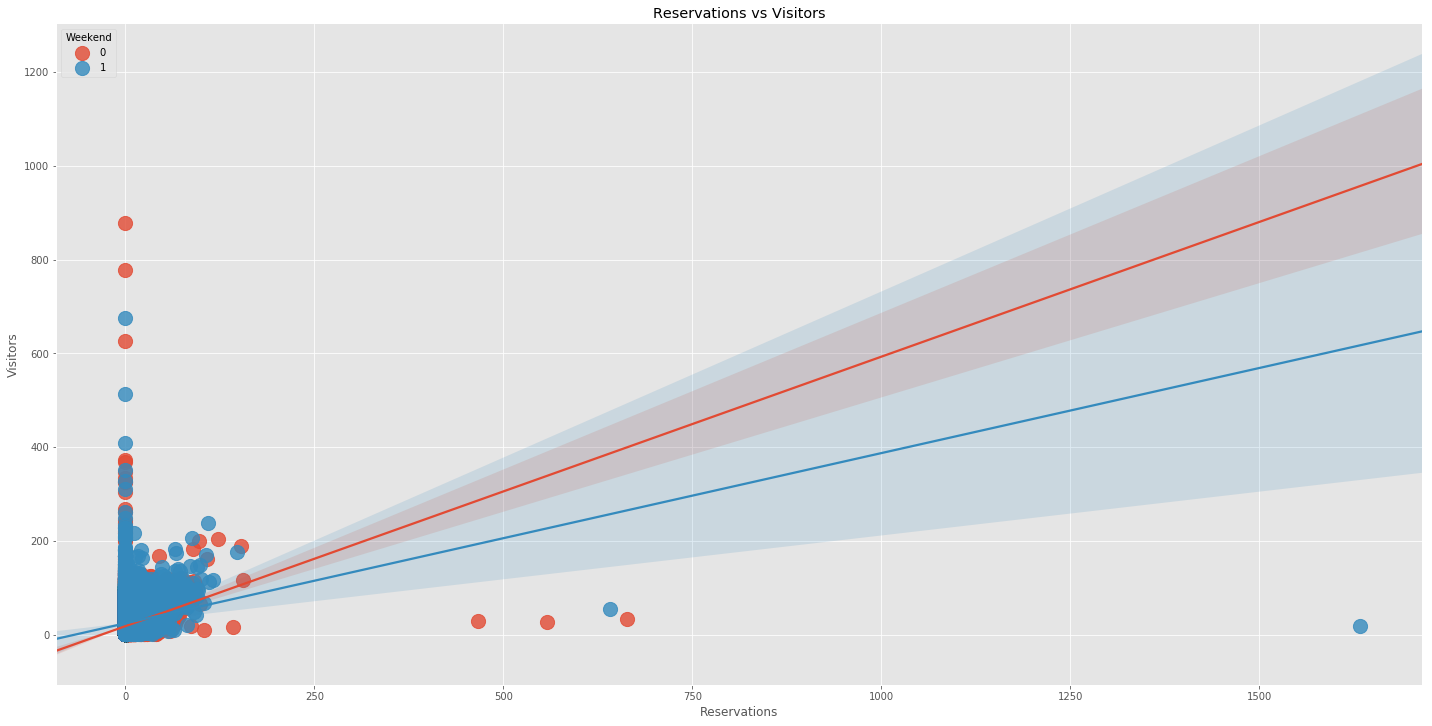

In [35]:
# Generate plot to identify spread of driving metric distributions
ax = sns.lmplot(x='Reservations', y='Visitors', data=air_final, hue='Weekend', fit_reg=True, size=10, aspect=2, legend=False, scatter_kws={"s": 200})
ax.set(xlabel='Reservations', ylabel='Visitors', title="Reservations vs Visitors")
plt.legend(loc='upper left', title='Weekend')
plt.show()

In [36]:
# Just based off of a high level regression model, we can tell this won't work
model = smf.ols('Visitors ~ Reservations', data=air_final).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Visitors   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                 1.126e+04
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:18:56   Log-Likelihood:            -1.0629e+06
No. Observations:              252108   AIC:                         2.126e+06
Df Residuals:                  252106   BIC:                         2.126e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       20.2380      0.033    606.281   

In [37]:
# Create a correlation matrix to assess variable relationship
df_disti_2 = air_final[["Log_Reservations","Log_Visitors"]].copy()
df_disti_2.corr()

,Log_Reservations,Log_Visitors
Log_Reservations,1.000000,0.582501
Log_Visitors,0.582501,1.000000


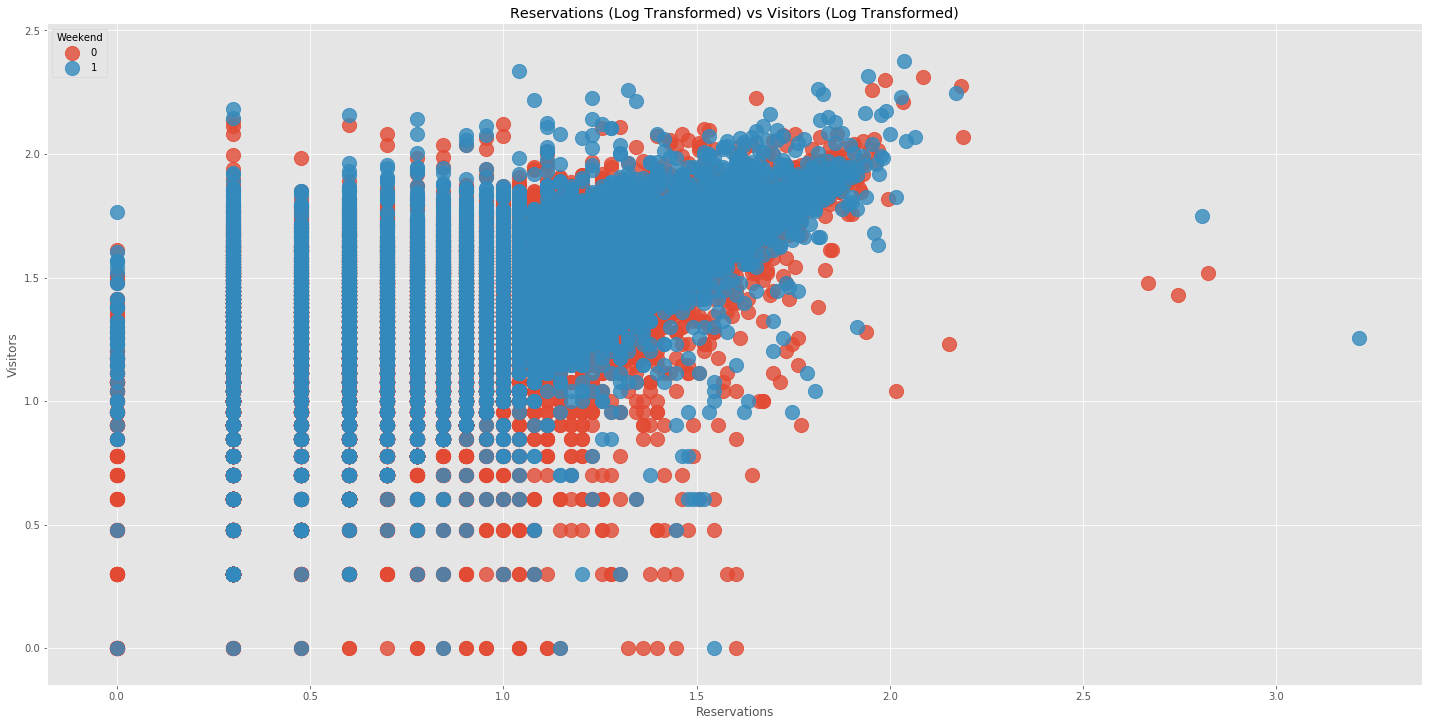

In [38]:
# Generate plot to identify spread of driving metric distributions
bx = sns.lmplot(x='Log_Reservations', y='Log_Visitors', data=air_final, hue='Weekend', fit_reg=True, size=10, aspect=2, legend=False, scatter_kws={"s": 200})
bx.set(xlabel='Reservations', ylabel='Visitors', title="Reservations (Log Transformed) vs Visitors (Log Transformed)")
plt.legend(loc='upper left', title='Weekend')
plt.show()

In [39]:
# Just based off of a high level regression model, we can tell this won't work
air_final = air_final.loc[air_final['Log_Visitors'] > 0]
air_final = air_final.loc[air_final['Log_Reservations'] > 0]
model_2 = smf.ols('Log_Visitors ~ Log_Reservations', data=air_final).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:           Log_Visitors   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                 1.451e+04
Date:                Fri, 09 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:19:13   Log-Likelihood:                -2622.3
No. Observations:               27786   AIC:                             5249.
Df Residuals:                   27784   BIC:                             5265.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8448      0.004  

<hr style="width:50%;">
## <a id="five">Feature Selection</a>
<p><a href="#toc">Jump to top</a></p>

This is a time-series regression that will ultimately be used to predict the number of visitors to a store on a given day. The factors that will contribute to this are:
* Seasonality (time of year, this time last year, day of week, day of month, etc.)
* Holiday
* Weather
* Restaurant Genre
* Location
* Number of reservations

<hr style="width:50%;">
## <a id="six">Model Development</a>
<p><a href="#toc">Jump to top</a></p>

#### ARIMA / auto.arima

##### Here are some sites used as amazing resources for creating an ARIMA model in python
Most of the inspiration for the code in this section come from the first link, while much of the learning about how and why many of these steps are taken is done from a variety of sources:
* https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
    * Excellent step-through of a simple shampoo sales timeseries problem. Data is downloadable and reproduceable
* https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    * This goes into much more depth about some of the statistics involved, and a lot of alternative solutions to try out

ARIMA is a special use case of regression that applies a regression framework to time series data through lags of the dependent variable.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

* AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.




In [43]:
timeseries = air[['air_store_id','visit_date','total_visitors']].copy()

In [44]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [137]:
# putting all the above code into two functions

def pre_arima(id):
    # create a subset of that store id
    timeseries_subset = timeseries[timeseries['air_store_id']==id]
    
    # data cleaning steps
    timeseries_subset=timeseries_subset.drop('air_store_id',axis=1)
    timeseries_subset['total_visitors'] = timeseries_subset['total_visitors'].astype('float64')
    timeseries_subset.set_index('visit_date', inplace=True)
    
    # plot a simple timeseries
    timeseries_subset.plot()
    pyplot.title("Timeseries Plot")
    pyplot.show()
    
    # autocorrelation plot
    autocorrelation_plot(timeseries_subset)
    pyplot.title("Autocorrelation Plot")
    pyplot.show()

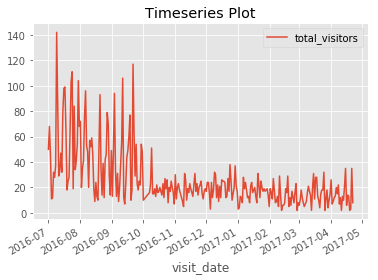

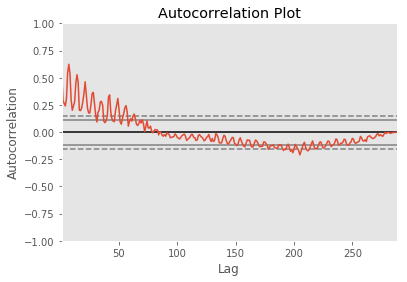

In [138]:
pre_arima('air_6836438b543ba698')

In [79]:
# The parameters of the ARIMA model are defined as follows:
## p: The number of lag observations included in the model, also called the lag order.
## d: The number of times that the raw observations are differenced, also called the degree of differencing.
## q: The size of the moving average window, also called the order of moving average.

def arima_summary(id,lag,differencing,ma_window):
    # create a subset of that store id
    timeseries_subset = timeseries[timeseries['air_store_id']==id]
    
    # data cleaning steps
    timeseries_subset=timeseries_subset.drop('air_store_id',axis=1)
    timeseries_subset['total_visitors'] = timeseries_subset['total_visitors'].astype('float64')
    timeseries_subset.set_index('visit_date', inplace=True)
    
    # create the model
    model = ARIMA(timeseries_subset, order=(lag,differencing,ma_window))
    
    # fit the model and print the summary
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    
    # plot the residuals and density plot
    residuals = DataFrame(model_fit.resid)
    residuals.plot()
    pyplot.title("Residuals Plot")
    pyplot.show()
    residuals.plot(kind='kde')
    print(residuals.describe())
    pyplot.title("Density Plot of Residuals")
    pyplot.show()
    
   
    # test the predicticted values and determine a MSE
    X = timeseries_subset.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(lag,differencing,ma_window))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    pyplot.plot(test, color='blue')
    pyplot.plot(predictions, color='red')
    pyplot.title("Predictions (red) vs Expected (blue)")
    pyplot.show()

Store ID examples and their (p,d,q)

* air_9d93d95720f2e831
    * (5,1,0)
* air_3982a2c4ea2ed431
    * (6,1,0)
* air_aed3a8b49abe4a48
    * (10,0,0)
* air_6836438b543ba698
    * (75,0,0)

                             ARIMA Model Results                              
Dep. Variable:       D.total_visitors   No. Observations:                  357
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1031.022
Method:                       css-mle   S.D. of innovations              4.337
Date:                Fri, 09 Mar 2018   AIC                           2076.044
Time:                        16:04:37   BIC                           2103.188
Sample:                    01-05-2016   HQIC                          2086.840
                         - 04-22-2017                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0078      0.057      0.137      0.892      -0.104       0.120
ar.L1.D.total_visitors    -0.9221      0.052    -17.698      0.000      -1.024      -0.820
ar.L

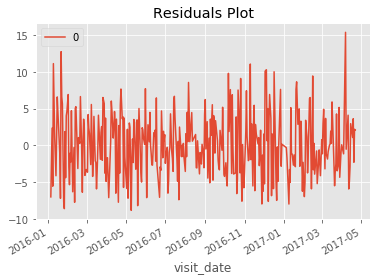

                0
count  357.000000
mean    -0.019500
std      4.353821
min     -8.842499
25%     -3.198341
50%     -0.315524
75%      3.123775
max     15.367107


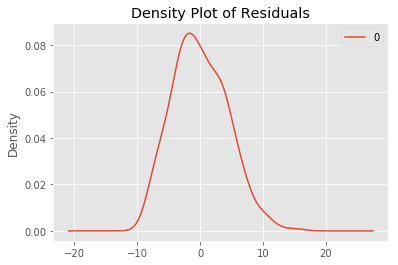

Test MSE: 21.284


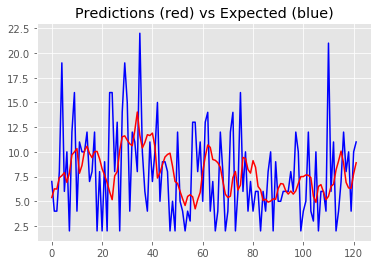

In [80]:
#pre_arima('air_9d93d95720f2e831')
arima_summary('air_9d93d95720f2e831',5,1,0)

# We've added 5 lag variables to this ARIMA model based on the autocorrelation plot
# Since it is not stationary, we difference it once with a d of 1
# The blue and red graph at the bottom shows the actual vs predicted visitors for this store

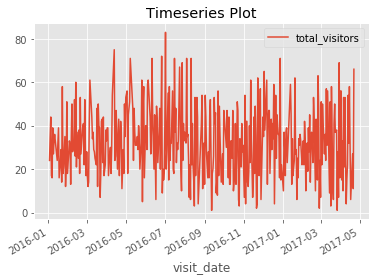

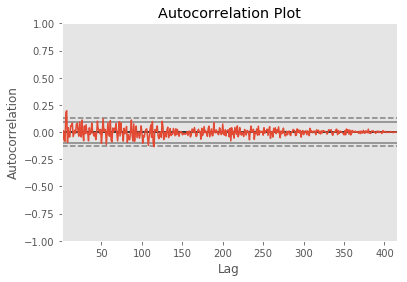

                             ARIMA Model Results                              
Dep. Variable:       D.total_visitors   No. Observations:                  414
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -1737.293
Method:                       css-mle   S.D. of innovations             16.030
Date:                Fri, 09 Mar 2018   AIC                           3490.585
Time:                        16:04:57   BIC                           3522.792
Sample:                    01-04-2016   HQIC                          3503.322
                         - 04-22-2017                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0086      0.140      0.061      0.951      -0.266       0.283
ar.L1.D.total_visitors    -1.0586      0.046    -22.996      0.000      -1.149      -0.968
ar.L

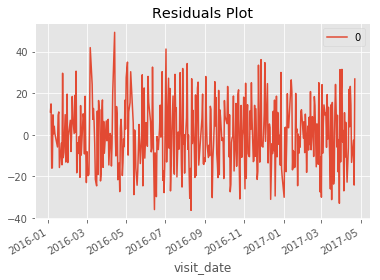

                0
count  414.000000
mean     0.014921
std     16.073746
min    -36.317991
25%    -11.897938
50%     -0.680026
75%     11.170924
max     49.258550


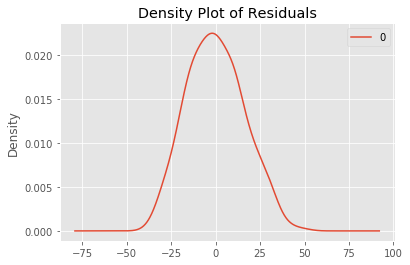

Test MSE: 268.769


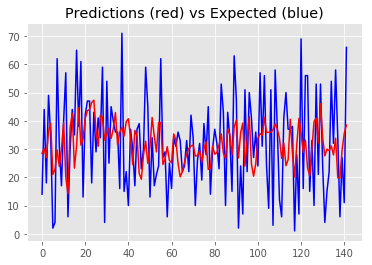

In [81]:
pre_arima('air_3982a2c4ea2ed431')
arima_summary('air_3982a2c4ea2ed431',6,1,0)

<hr style="width:50%;">
## <a id="seven">Interpretation</a>
<p><a href="#toc">Jump to top</a></p>

We have run the ARIMA forecasting model on a number of stores as you can see above. By doing so, we can predict, with some reasonable degree of accuracy, the number of visitors on any given day for a restaurant in the AirREGI system.

We are performing a simple timeseries analysis with this model, but it represents the foundation upon which we can add more variables to achieve a more robust and accurate model. For now, a model that provides a prediction is the most valuable thing so we can provide a solution of some sort.

<hr style="width:50%;">
## <a id="eight">Recommendation</a>
<p><a href="#toc">Jump to top</a></p>

While we built an ARIMA model that can predict visitor numbers for a particular store in the future, we also recognize the need to create a business solution for the stores that Recruit Holdings has data for. Recruit Holdings is in a unique position to deliver customized insights to the restaurants it partners with, and those insights are driven by the data it collects and the model we built for them.

One way that they can add value is to display the trends held within the data that they are collecting for their clients. We took some of the most informative insights from our exploratory analysis above, and collected it into a client-facing dashboard. With a tool like this, Recruit Holdings can see an overview of their restaurants, and easily tailor such a dashboard to a specific restaurant in their system. Since they have both the AirREGI system and the Hot Pepper Gourmet system, we created dashboards that provide an overview of each of these.

This dashboard focuses on the exploratory analysis that was performed, but can easily be improved to include predictions provided by the ARIMA model that we built out. We envision such a dashboard being used to dive deep into custom, predictive insights for any restaurant in the Recruit Holdings database of restaurants.

Below is the first version of such a dashboard:

In [51]:
%%HTML
<div class='tableauPlaceholder' id='viz1520620682197' style='position: relative'><noscript><a href='#'><img alt='AIR Dashboard ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;RetailForecastingEDA&#47;AIRDashboard&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='RetailForecastingEDA&#47;AIRDashboard' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;RetailForecastingEDA&#47;AIRDashboard&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1520620682197');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='827px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>